# Задача 1


Требуется получить состояние:
$$
\ket{\psi} = \frac{1}{\sqrt{45}} \sum_{k = 1}^{45} \ket{2k - 1}
$$

Наша команда решила использовать вариационную квантовую схему (VQC) для приближение искомого состояния. Мы вдохновлялись данной статьёй  https://doi.org/10.1002/qute.201900070, в которой предложены разные вариационные схемы для приближения любого состояния. Наша команда выбрала схему 6 (circuit 6) с рисунка 2, так как она является самой выразительной. 

Мы использовали Fidelity как функцию ошибки. Fidelity является физически измеримой и наиболее логичной лосс функцией, так как она определяет меру близости между состояними. Пусть $U(\boldsymbol{\theta})$ - анзатц, а $\ket{\psi}$ - вектор состояния, который мы хотим получить, $\ket{0}$ - исходное вакуумное состояние. Тогда фиделити определяется как

$$
Fid = \bra{\psi} U(\boldsymbol{\theta}) \ket{0}
$$

Максимальное значение фиделити равно 1, то есть когда состояние $\ket{\psi}$ совпадает с $U(\boldsymbol{\theta})\ket{0}$.

Импорт нужных библиотек

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
torch.set_default_dtype(torch.float64)

Код для визуализации схем и состояний.

In [59]:
def get_res_state(params, circuit, n_layers, number_of_odds = 45):
    num_qubits = int(np.ceil(np.log2(2 * number_of_odds - 1)))
    vector = circuit(params, n_layers).detach().numpy()
    state_ampl = dict()
    for i in range(0, 1 << num_qubits):
        s = f"|{i}>"
        state_ampl[s] = np.round(np.abs(vector[i]), 3)
    return state_ampl

def plot_res_state(state_ampl):
    plt.figure(figsize=(55,10))
    plt.bar(range(len(state_ampl)), state_ampl.values(), width=1, edgecolor='black', facecolor='skyblue')
    plt.hlines(1/np.sqrt(45), 0, len(state_ampl), color='red', linestyles='--')
    plt.xticks(range(len(state_ampl)), state_ampl.keys(), rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'Состояния', fontsize=30)
    plt.ylabel(r'Вероятности', fontsize=30)
    plt.title(r'Итоговое распределение вероятностей для состояния $|\psi\rangle = \frac{1}{\sqrt{45}}\ \sum_{n = 0}^{45} |2k-1\rangle$', fontsize=40)
    plt.tight_layout()
    plt.show()

def print_circuit(circuit, params, n_layers):
    fig, ax = qml.draw_mpl(circuit)(params, n_layers=n_layers)
    plt.show()

def plot_all_fidelities(fid_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Итерация')
    plt.ylabel('Фиделити')
    plt.title('Эволюция фиделити во время обучения')
    plt.grid(True)
    for circ in fid_circ.keys():
        plt.plot(fid_circ[circ], label=f'Схема {circ}')
    plt.legend()
    plt.show()

def plot_bar_num_of_pars(pars_circ):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер схемы')
    plt.ylabel('Количество параметров')
    plt.title('Гистограмма числа параметров')
    plt.grid(True)
    for circ in pars_circ.keys():
        plt.bar(circ, len(pars_circ[circ]), label=f'Схема {circ}')
    plt.legend()
    plt.show()

Fidality

In [14]:
def fidelity_loss(predicted, target):
    inner = torch.vdot(target, predicted)
    fid = torch.abs(inner) ** 2
    loss = 1 - fid
    return loss, fid

Кодируем целые числа в исходном состоянии в битовые строки из 7 битов. В схеме 7 кубит, так как 45-ое нечетное число - это 89. А $2^6 = 64 < 89 < 128 = 2^7$.

In [5]:
def create_target_state():
    target = np.zeros(128, dtype=np.complex128)
    for k in range(1, 46):
        target[2 * k - 1] = 1.0
    target /= np.sqrt(45)
    return torch.tensor(target, dtype=torch.complex128)

Создаем анзац. Количество анзацов в схеме == 10

In [51]:
n_qubits = 7
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit6(params, n_layers=10):
    param_idx = 0
    for _ in range(n_layers):
        for w in range(n_qubits):
            qml.RX(params[param_idx], wires=w); param_idx += 1
            qml.RZ(params[param_idx], wires=w); param_idx += 1
        for ctrl in range(n_qubits):
            for tgt in range(n_qubits):
                if ctrl != tgt:
                    qml.CRX(params[param_idx], wires=[ctrl, tgt]); param_idx += 1
    return qml.state()

Функция обучения. Оптмизатор Adam, шаг обучения 0.01, 310 итераций. + планировщик уменьшающий в два раза шаг обучения, если loss не уменьшается в течении 50 итераций

In [52]:
def train_pennylane_circuit(
    n_layers=10,
    n_epochs=300,
    lr=0.01,
):
    target = create_target_state()
    n_params = n_layers * n_qubits * (n_qubits + 1)
    params = nn.Parameter(
        torch.empty(n_params, dtype=torch.float64).uniform_(-torch.pi, torch.pi)
    )
    optimizer = torch.optim.Adam([params], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=50, factor=0.5)

    fidelities = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        state = circuit6(params, n_layers=n_layers)
        loss, fid = fidelity_loss(state, target)
        loss.backward()
        optimizer.step()
        scheduler.step(fid.item())

        fidelities.append(fid.item())
        if epoch % 10 == 0:
            print(f"Epoch {epoch:4d} | Fidelity: {fid.item():.12f}")

    return fidelities, params


Тренируем нашу схему на 10 слоях и 310 эпохах. В результате мы подберем необходимые параметры.

Epoch    0 | Fidelity: 0.010188390129
Epoch   10 | Fidelity: 0.591629665919
Epoch   20 | Fidelity: 0.870478744163
Epoch   30 | Fidelity: 0.966244429519
Epoch   40 | Fidelity: 0.990771129320
Epoch   50 | Fidelity: 0.995174592887
Epoch   60 | Fidelity: 0.998523410833
Epoch   70 | Fidelity: 0.999502893599
Epoch   80 | Fidelity: 0.999780877742
Epoch   90 | Fidelity: 0.999930188530
Epoch  100 | Fidelity: 0.999974957174
Epoch  110 | Fidelity: 0.999990628289
Epoch  120 | Fidelity: 0.999996834662
Epoch  130 | Fidelity: 0.999998868271
Epoch  140 | Fidelity: 0.999999609933
Epoch  150 | Fidelity: 0.999999863878
Epoch  160 | Fidelity: 0.999999947612
Epoch  170 | Fidelity: 0.999999983005
Epoch  180 | Fidelity: 0.999999994303
Epoch  190 | Fidelity: 0.999999998511
Epoch  200 | Fidelity: 0.999999999383
Epoch  210 | Fidelity: 0.999999999743
Epoch  220 | Fidelity: 0.999999999906
Epoch  230 | Fidelity: 0.999999999970
Epoch  240 | Fidelity: 0.999999999991
Epoch  250 | Fidelity: 0.999999999997
Epoch  260 |

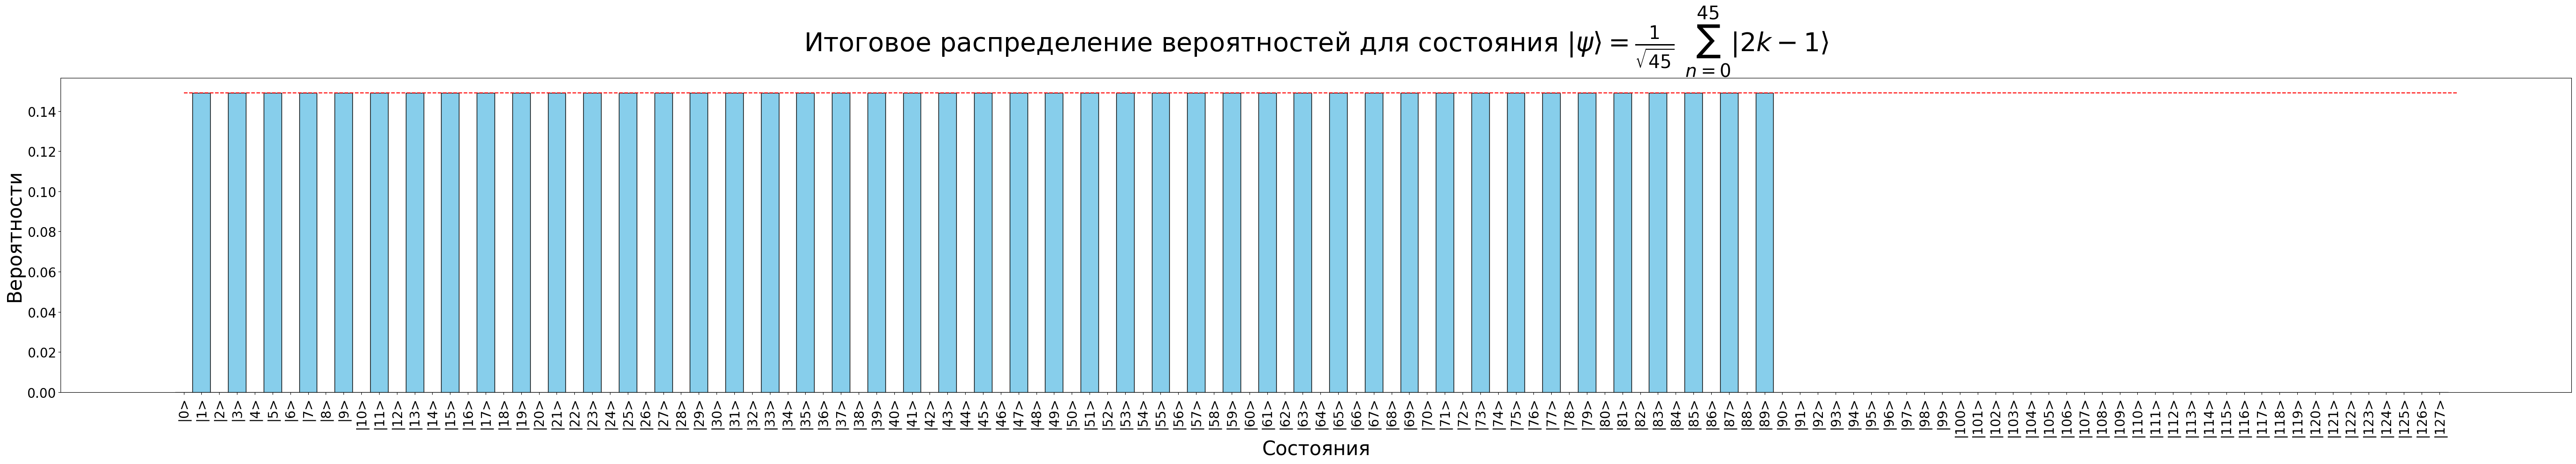

In [53]:
n_layers = 10
n_epochs = 310

fid_circ = {}
par_circ = {}
circ = '6'
fid_circ[circ], par_circ[circ] = train_pennylane_circuit(n_layers=n_layers, n_epochs=n_epochs)
state_ampl = get_res_state(par_circ[circ], circuit=circuit6, number_of_odds=45, n_layers=n_layers)
plot_res_state(state_ampl)

Красным пунктиром показан уровень $\frac{1}{\sqrt{45}}$ - вероятность, которую должно иметь каждое нечетное число.

График обучения + количество параметров в схеме

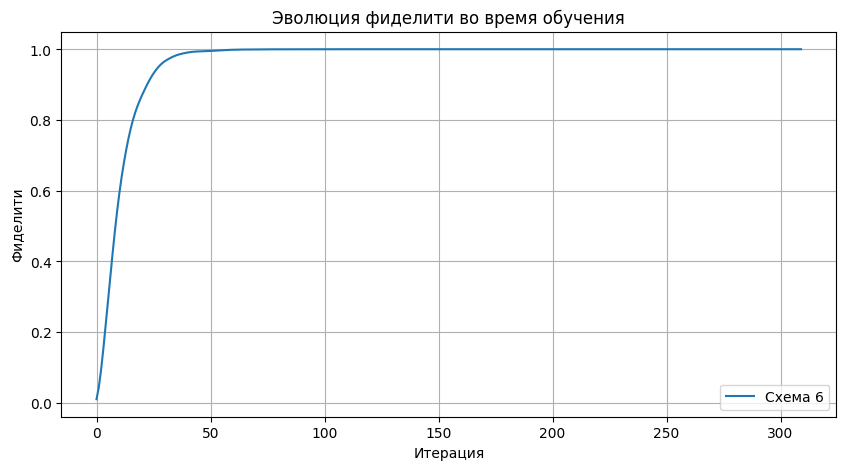

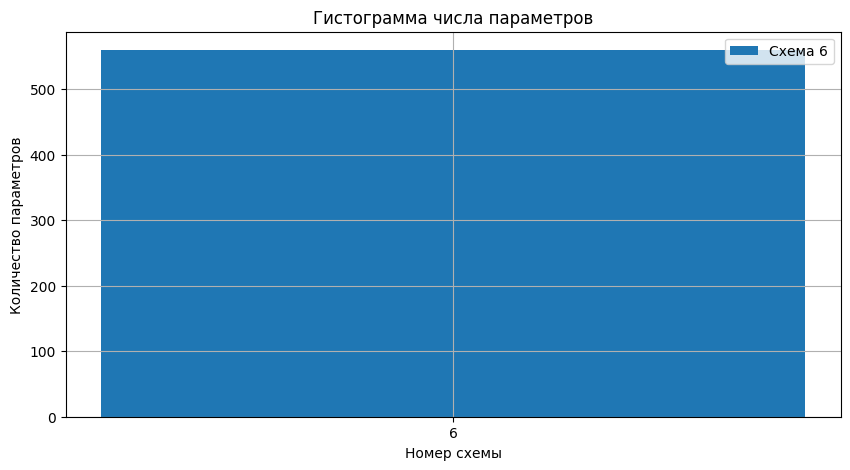

In [60]:
plot_all_fidelities(fid_circ)
plot_bar_num_of_pars(par_circ)

Рисунок схемы. Один слой. Таких слоев мы использовали 10, чтобы получить максимальную сходимость.


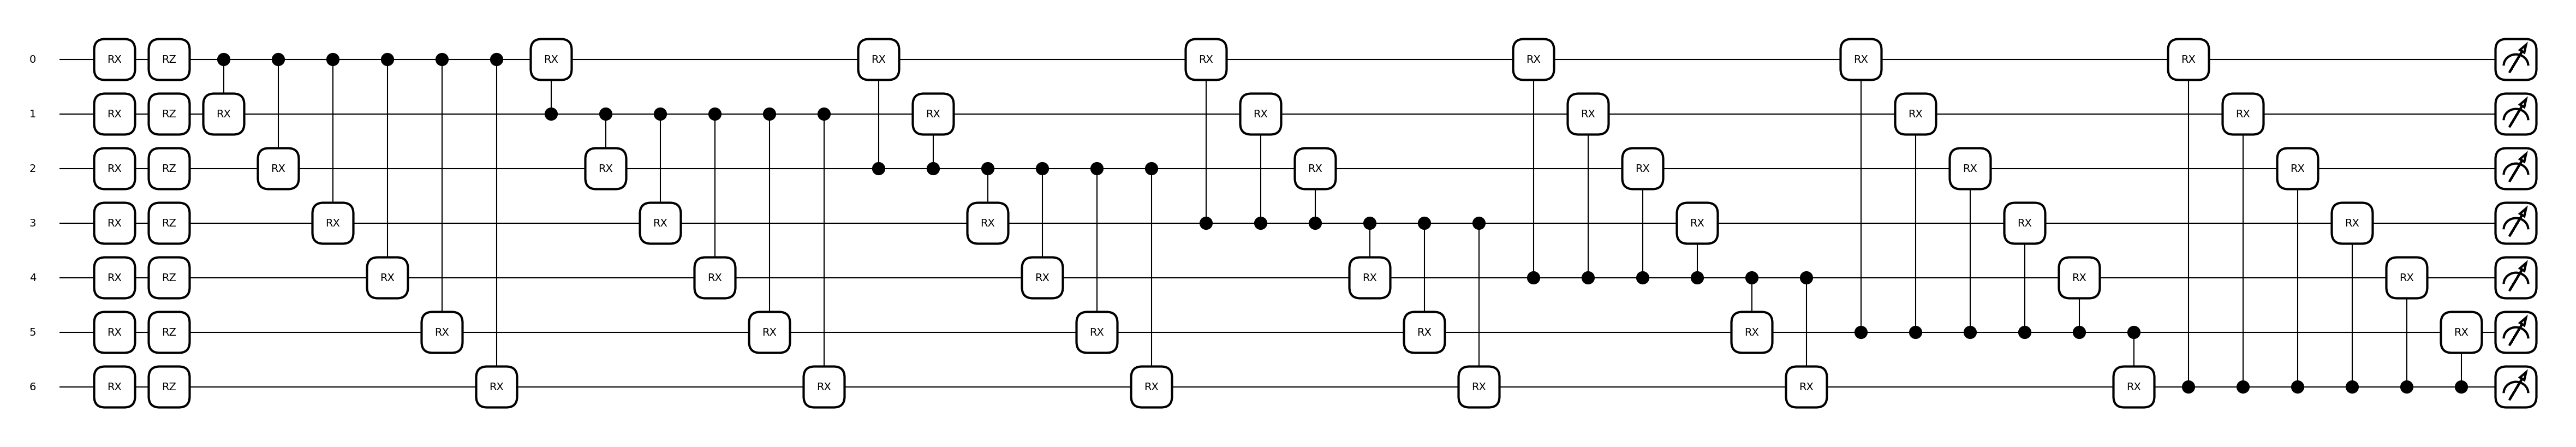

In [ ]:
print_circuit(circuit6, par_circ[circ], 1)

Выводим состояние финальное состояние, чтобы убедиться, что мы получаем вероятности $\frac{1}{\sqrt{45}} \approx 0.149$

In [63]:
print(get_res_state(par_circ['6'], circuit=circuit6, number_of_odds=45, n_layers=n_layers))

{'|0>': np.float64(0.0), '|1>': np.float64(0.149), '|2>': np.float64(0.0), '|3>': np.float64(0.149), '|4>': np.float64(0.0), '|5>': np.float64(0.149), '|6>': np.float64(0.0), '|7>': np.float64(0.149), '|8>': np.float64(0.0), '|9>': np.float64(0.149), '|10>': np.float64(0.0), '|11>': np.float64(0.149), '|12>': np.float64(0.0), '|13>': np.float64(0.149), '|14>': np.float64(0.0), '|15>': np.float64(0.149), '|16>': np.float64(0.0), '|17>': np.float64(0.149), '|18>': np.float64(0.0), '|19>': np.float64(0.149), '|20>': np.float64(0.0), '|21>': np.float64(0.149), '|22>': np.float64(0.0), '|23>': np.float64(0.149), '|24>': np.float64(0.0), '|25>': np.float64(0.149), '|26>': np.float64(0.0), '|27>': np.float64(0.149), '|28>': np.float64(0.0), '|29>': np.float64(0.149), '|30>': np.float64(0.0), '|31>': np.float64(0.149), '|32>': np.float64(0.0), '|33>': np.float64(0.149), '|34>': np.float64(0.0), '|35>': np.float64(0.149), '|36>': np.float64(0.0), '|37>': np.float64(0.149), '|38>': np.float64(0.